# Prepare the notebook

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Consegne

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/Consegne


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as tfk

from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

seed = 42

In [ ]:
!pip install keras-cv
import keras_cv

# ⏳ **LOAD DATA**

In [ ]:
#Load data from a dataset without outlier
data = np.load('datasetWithout.npz')
images = data['x_train']
labels = data['y_train']
#Initial random permutation
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

In [ ]:
#Normalization for images and categorical form for labels
images = images / 255.0
labels = to_categorical(labels).astype('float32')

# 🔀 **Processing data**

In [ ]:
#SPlit the data, validation images are not augmented
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [ ]:
#Prepare random augmentation, only one augmentation per images is applied
data_augmentation = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed)
    ],
    seed=seed,
    augmentations_per_image=1
)

In [ ]:
#Trasfor dataset into tensor
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(512)

In [ ]:
#Apply augmentation
def augment_images(image, label):
    image = data_augmentation(image)
    return image, label
train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
#Recreation of np array
x_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    x_train.append(images)
    y_train.append(labels)
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

In [ ]:
#Applay a second type of augmentation
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

# Define the CutMix layer
cutmix = keras_cv.layers.CutMix(seed=seed)

# Define a function to apply CutMix to a batch
def apply_advanced_augmentation(images, labels):
    return cutmix({"images": images, "labels": labels})

# Apply data augmentation and CutMix to the train dataset
train_dataset = train_dataset.map(lambda x, y: apply_advanced_augmentation(x, y))

In [ ]:
X_train, y_train = [], []
for batch in train_dataset:
    images = batch["images"].numpy()
    labels = batch["labels"].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
del train_dataset

# 🔀 **Model**

In [ ]:
#Define the squeeze and excitation block
def senet_block(x, filters, kernel_size=3, padding='same', downsample=True, activation='relu', stack=2, name='senet'):
    #Number of squeeze block to insert
    for s in range(stack):
        #Convolution layer
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, use_bias=False, name=f'{name}_conv_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act_{s}')(x)

        channels = x.shape[-1]
        #Squeeze creation
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:
#Model parameters
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.001
batch_size = 32
epochs = 400

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):

      input_layer = tfkl.Input(shape=input_shape, name='Input')

      #First convolution layer with batchnormalization, activation, dropout and maxpooling
      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=3)(x)
      x = tfkl.Dropout(0.2)(x)
      #Squeeze block
      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')
      #Second convolution layer with batchnormalization, activation, dropout and maxpooling
      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      #Squeeze block
      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')
      #Third convolution layer with batchnormalization, activation, dropout and maxpooling
      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.2)(x)
      #Squeeze block
      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')
      #fourth convolution layer with batchnormalization, activation, dropout and maxpooling
      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.2)(x)

      #GAP layer to flatten the volume
      global_average = tfkl.GlobalAveragePooling2D()(x)

      #Network's head
      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.5)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      # Return the compiled model
      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 96, 96, 64)   │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 32, 64)   │            0 │ activation[0][0]    │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 32, 32, 64)   │            0 │ max_pooling2d[0][0] │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 32, 32, 64)   │       36,864 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 32, 32, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)    

 Total params: 2,409,188 (9.19 MB)

 Trainable params: 2,406,116 (9.18 MB)

 Non-trainable params: 3,072 (12.00 KB)

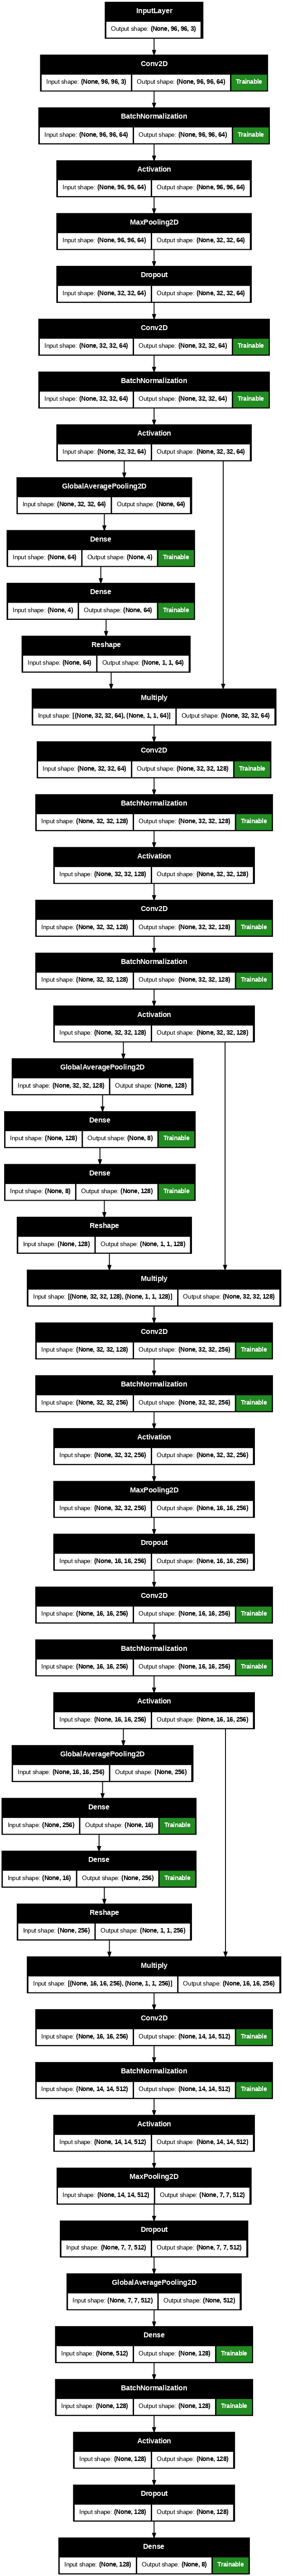

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
#Definition of early stopping to avoid overfitting
patience = 50

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


In [ ]:
del model

# 🏞 **Result analysis**

## Confusion matrix

299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


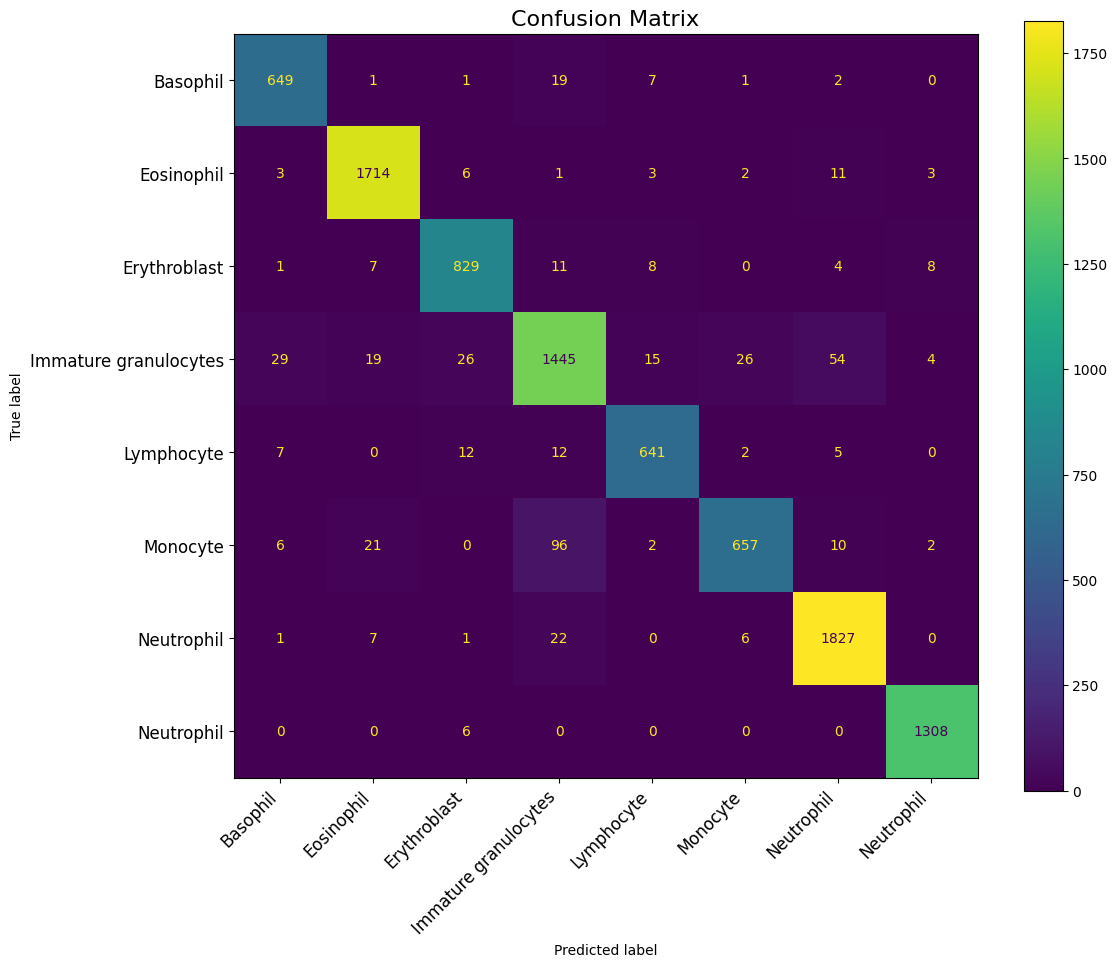

Accuracy: 94.87%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Load the model
model = tfk.models.load_model('SqueezeWeights.keras')

#Test the model with new image
y_pred = model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

#Creation of confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Platelet"]

# Set parameters to plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#Plot accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Regularization**

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):
      #Compared to the previous case, the regularizer has been added
      input_layer = tfkl.Input(shape=input_shape, name='Input')
      reg = tfk.L1L2(l1=0.01, l2=0.01)

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform',kernel_regularizer=reg)(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.2)(x)

      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform',kernel_regularizer=reg)(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.2)(x)

      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform',kernel_regularizer=reg)(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.2)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform',kernel_regularizer=reg)(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.2)(x)

      global_average = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.2)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer ,  name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 96, 96, 64)   │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 96, 96, 64)   │            0 │ activation[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 96, 96, 64)   │       36,864 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 96, 96, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 96, 96, 128)  │       73,856 │ block_squeeze_1_sc… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 96, 96, 128)  │          512 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization) 

 Total params: 2,409,188 (9.19 MB)

 Trainable params: 2,406,116 (9.18 MB)

 Non-trainable params: 3,072 (12.00 KB)

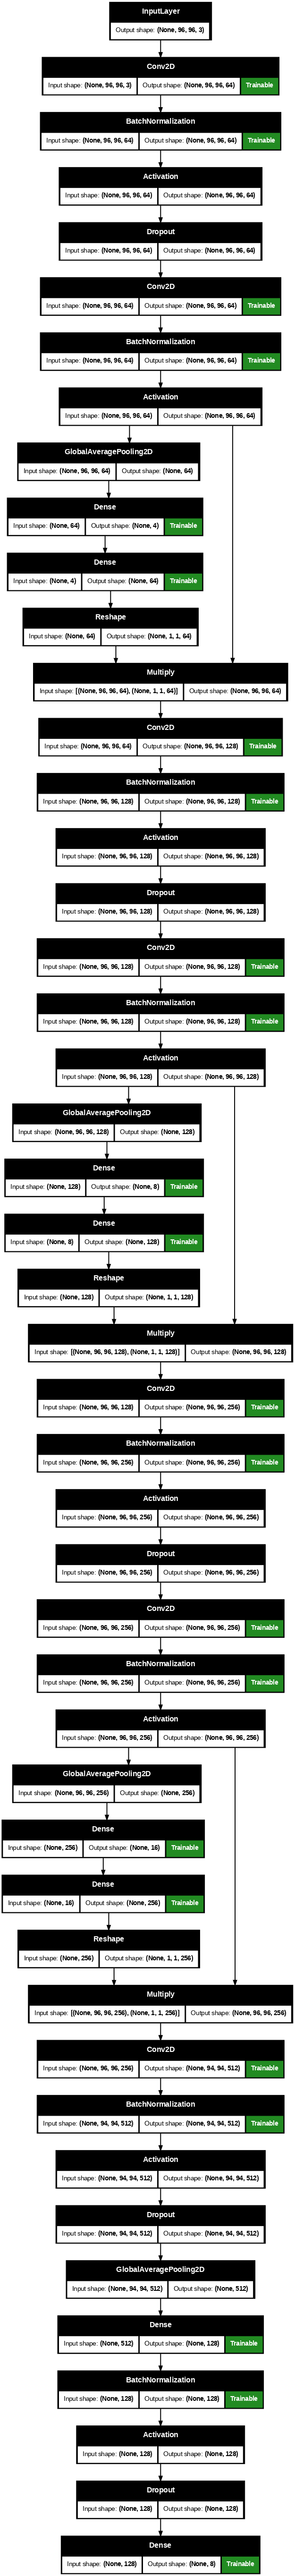

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
patience = 20

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.3222 - loss: 129.2175 - val_accuracy: 0.1376 - val_loss: 9.9731
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 245s 620ms/step - accuracy: 0.3841 - loss: 8.6101 - val_accuracy: 0.1949 - val_loss: 6.9144
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 210s 646ms/step - accuracy: 0.4206 - loss: 6.2641 - val_accuracy: 0.1694 - val_loss: 5.9940
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 192s 612ms/step - accuracy: 0.4421 - loss: 4.9779 - val_accuracy: 0.2405 - val_loss: 4.7706
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 201s 608ms/step - accuracy: 0.4572 - loss: 4.3630 - val_accuracy: 0.1305 - val_loss: 5.2853
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 201s 605ms/step - accuracy: 0.4782 - loss: 3.9592 - val_accuracy: 0.1794 - val_loss: 5.3765
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 201s 603ms/step - accuracy: 0.4824 - loss: 3.8172 - val_accuracy: 0.2886 - val_loss: 5.0315
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 201s 601ms/step - accuracy: 0

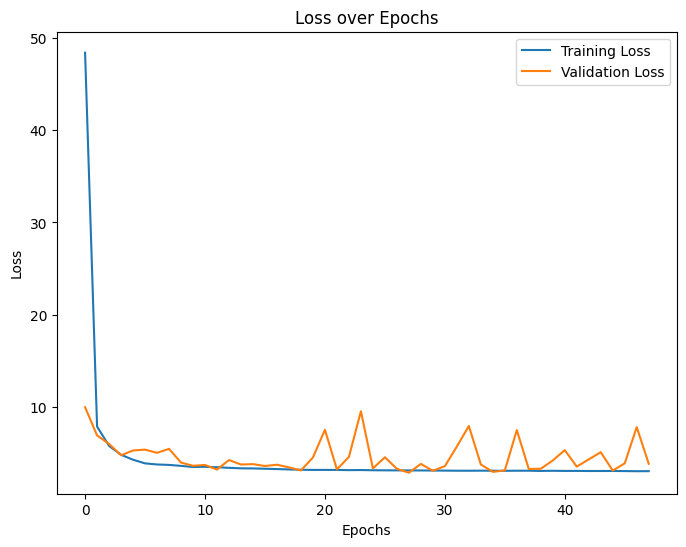

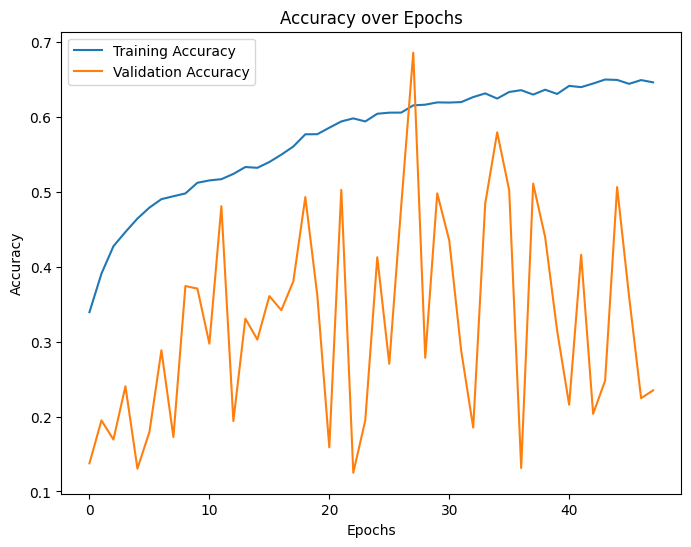

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step


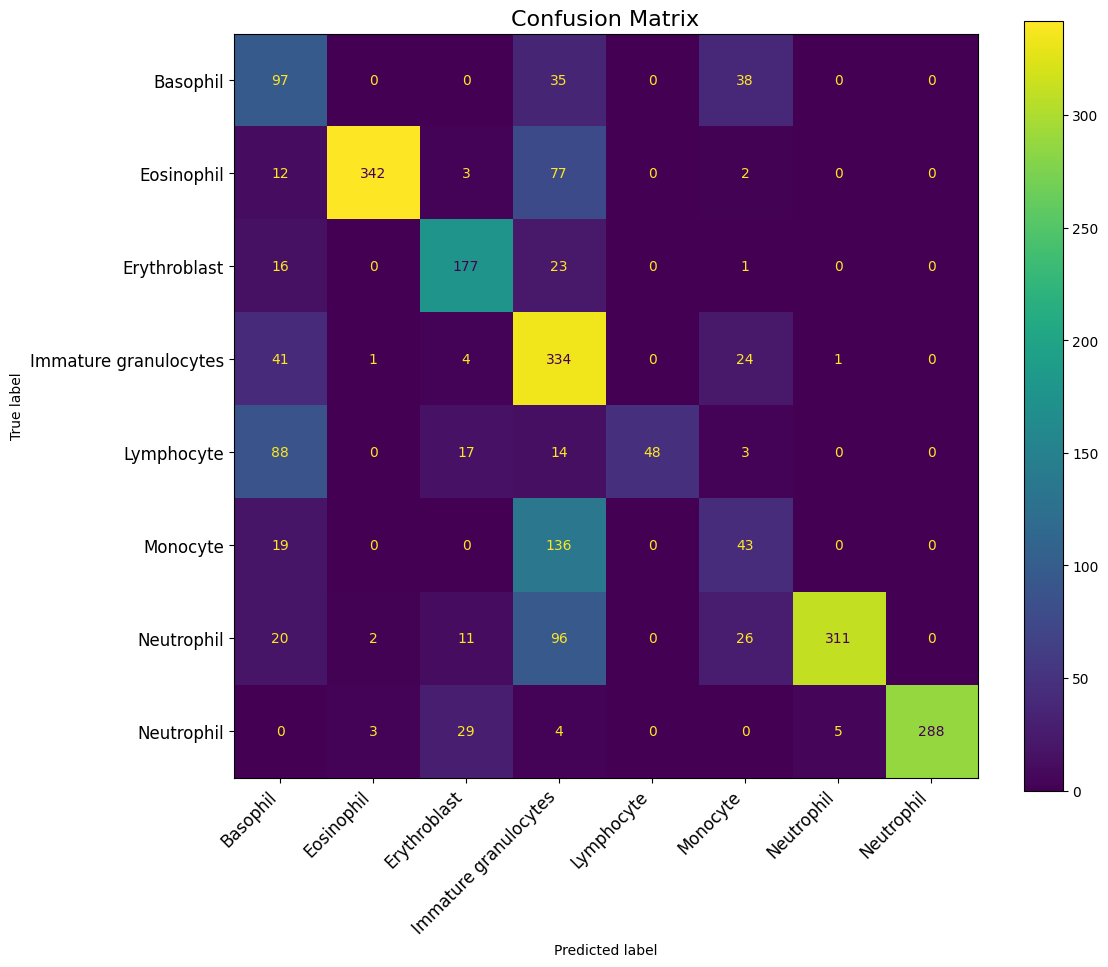

Accuracy: 68.59%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = model.predict(x_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_val.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Platelet"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Increased layers**

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):

      input_layer = tfkl.Input(shape=input_shape, name='Input')

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      #Added layer
      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_4')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      global_average = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer ,  name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 96, 96, 64)   │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 96, 96, 64)   │            0 │ activation[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 96, 96, 64)   │       36,864 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 96, 96, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 96, 96, 128)  │       73,856 │ block_squeeze_1_sc… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 96, 96, 128)  │          512 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization) 

 Total params: 3,599,604 (13.73 MB)

 Trainable params: 3,595,508 (13.72 MB)

 Non-trainable params: 4,096 (16.00 KB)

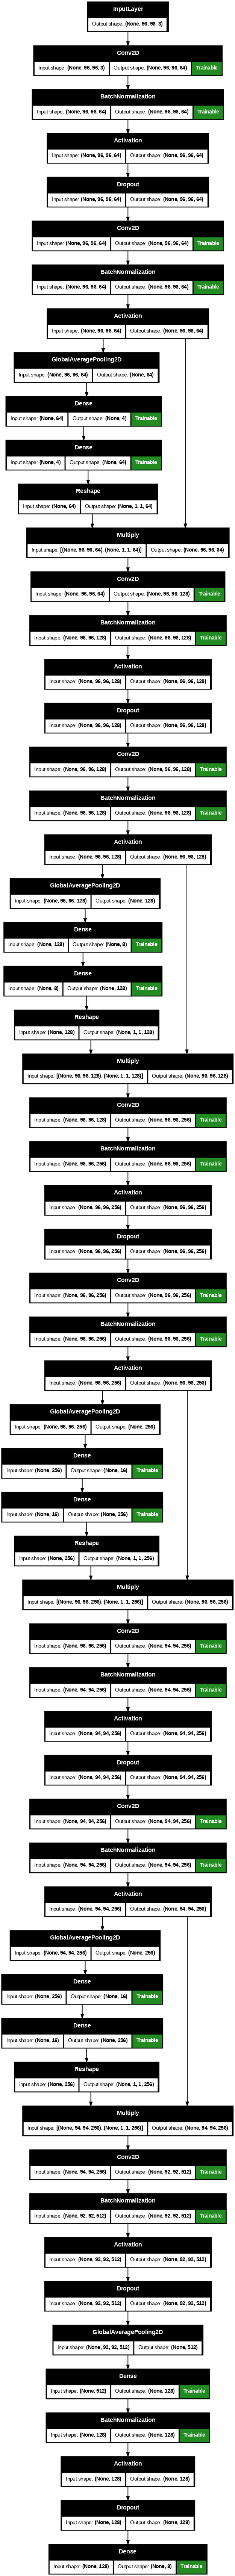

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.2178 - loss: 2.2434 - val_accuracy: 0.3325 - val_loss: 1.8530
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 292s 834ms/step - accuracy: 0.3260 - loss: 1.9223 - val_accuracy: 0.3890 - val_loss: 1.5835
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 266s 847ms/step - accuracy: 0.3778 - loss: 1.8272 - val_accuracy: 0.6207 - val_loss: 1.2145
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 249s 832ms/step - accuracy: 0.4059 - loss: 1.7288 - val_accuracy: 0.5563 - val_loss: 1.3743
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 262s 834ms/step - accuracy: 0.4643 - loss: 1.6013 - val_accuracy: 0.6002 - val_loss: 1.0860
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 261s 832ms/step - accuracy: 0.4756 - loss: 1.5680 - val_accuracy: 0.7223 - val_loss: 0.9019
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 262s 832ms/step - accuracy: 0.5135 - loss: 1.4885 - val_accuracy: 0.6688 - val_loss: 0.9073
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 262s 832ms/step - accuracy: 0.5

299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


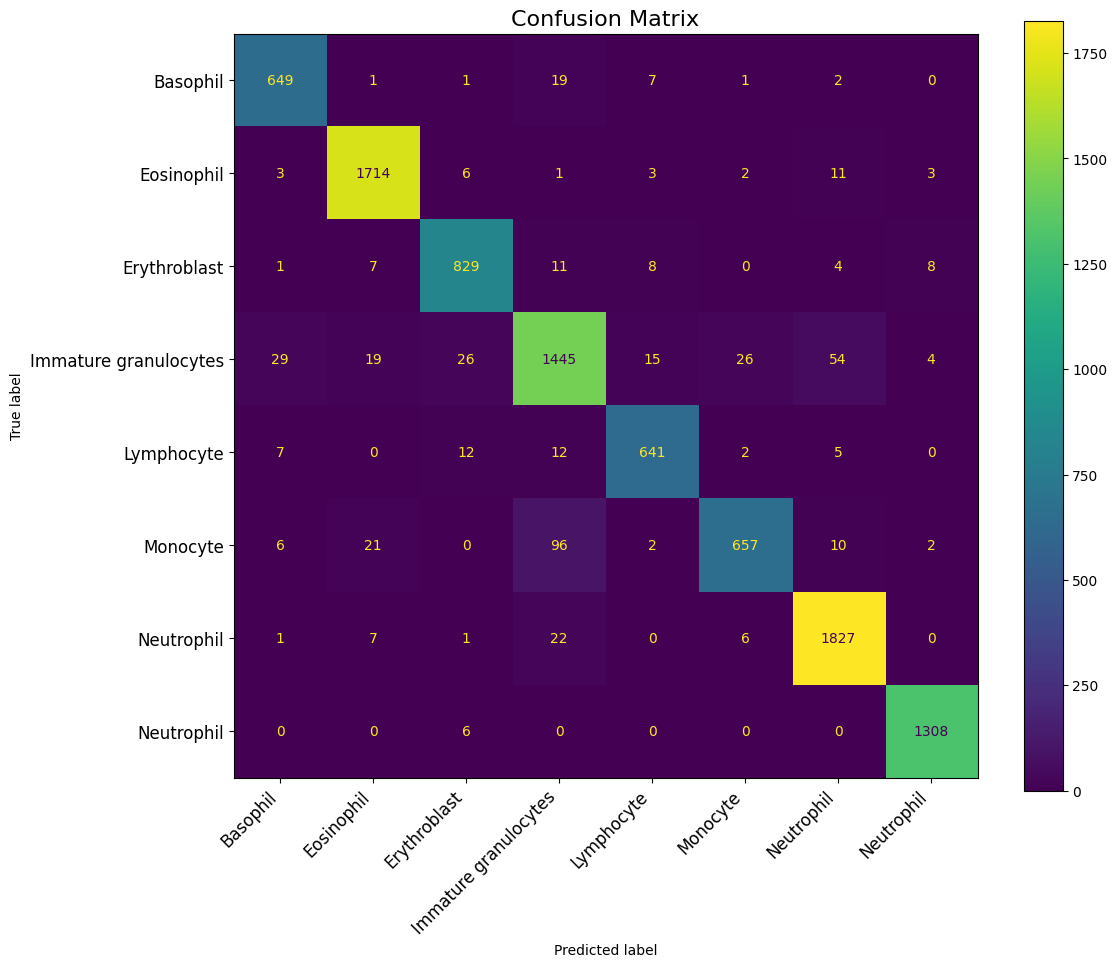

Accuracy: 94.87%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model = tfk.models.load_model('SqueezeWeights.keras')

y_pred = model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Neutrophil"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Increased Dropout**

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):
      #Dropout
      input_layer = tfkl.Input(shape=input_shape, name='Input')

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      global_average = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.4)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer ,  name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 96, 96, 64)   │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 96, 96, 64)   │            0 │ activation[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 96, 96, 64)   │       36,864 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 96, 96, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 96, 96, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 96, 96, 128)  │       73,856 │ block_squeeze_1_sc… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 96, 96, 128)  │          512 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization) 

 Total params: 2,409,188 (9.19 MB)

 Trainable params: 2,406,116 (9.18 MB)

 Non-trainable params: 3,072 (12.00 KB)

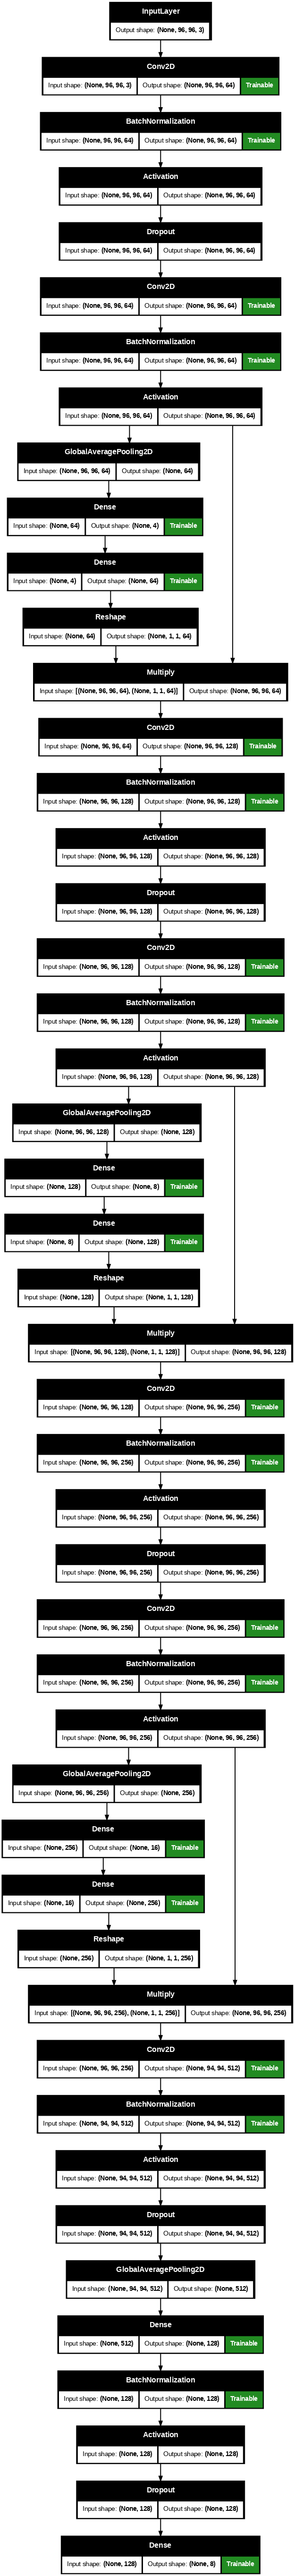

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.2315 - loss: 2.2275
Epoch 1: val_accuracy improved from -inf to 0.29987, saving model to Sq-01.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 333s 881ms/step - accuracy: 0.2316 - loss: 2.2270 - val_accuracy: 0.2999 - val_loss: 1.6097
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.3351 - loss: 1.8671
Epoch 2: val_accuracy improved from 0.29987 to 0.45588, saving model to Sq-02.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 240s 621ms/step - accuracy: 0.3351 - loss: 1.8670 - val_accuracy: 0.4559 - val_loss: 1.5064
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.3793 - loss: 1.7400
Epoch 3: val_accuracy did not improve from 0.45588
299/299 ━━━━━━━━━━━━━━━━━━━━ 193s 590ms/step - accuracy: 0.3794 - loss: 1.7400 - val_accuracy: 0.3936 - val_loss: 1.9760
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.4286 - loss: 1.6598
Epoch 4: val_accuracy improved from 0.45588 to 0.53074, saving mo

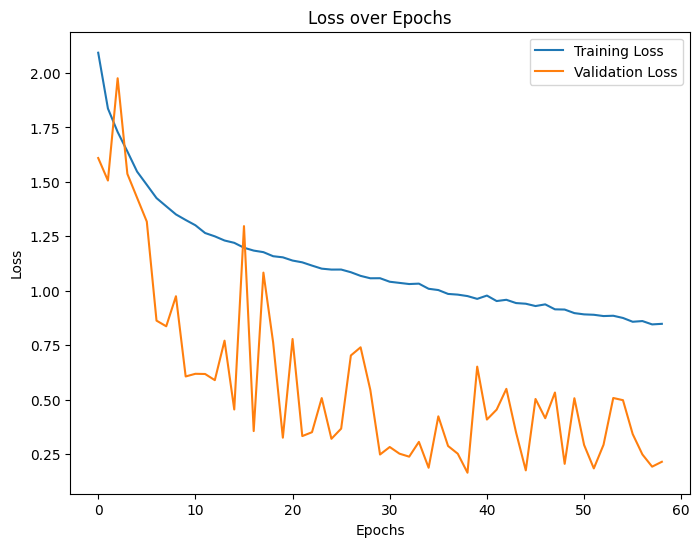

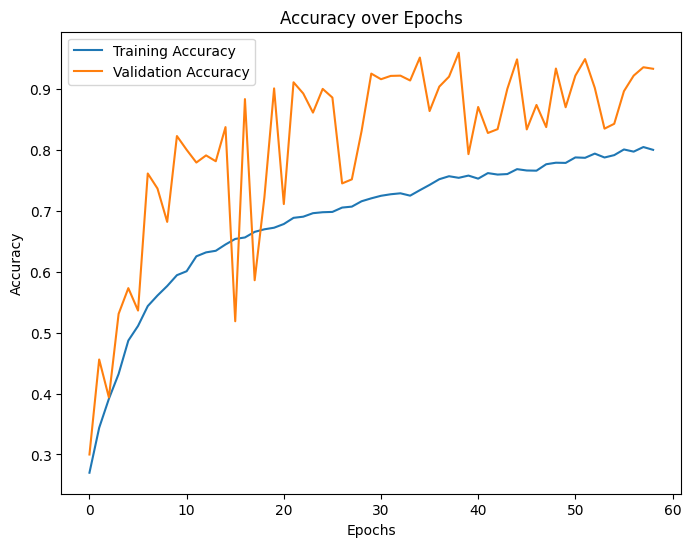

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step


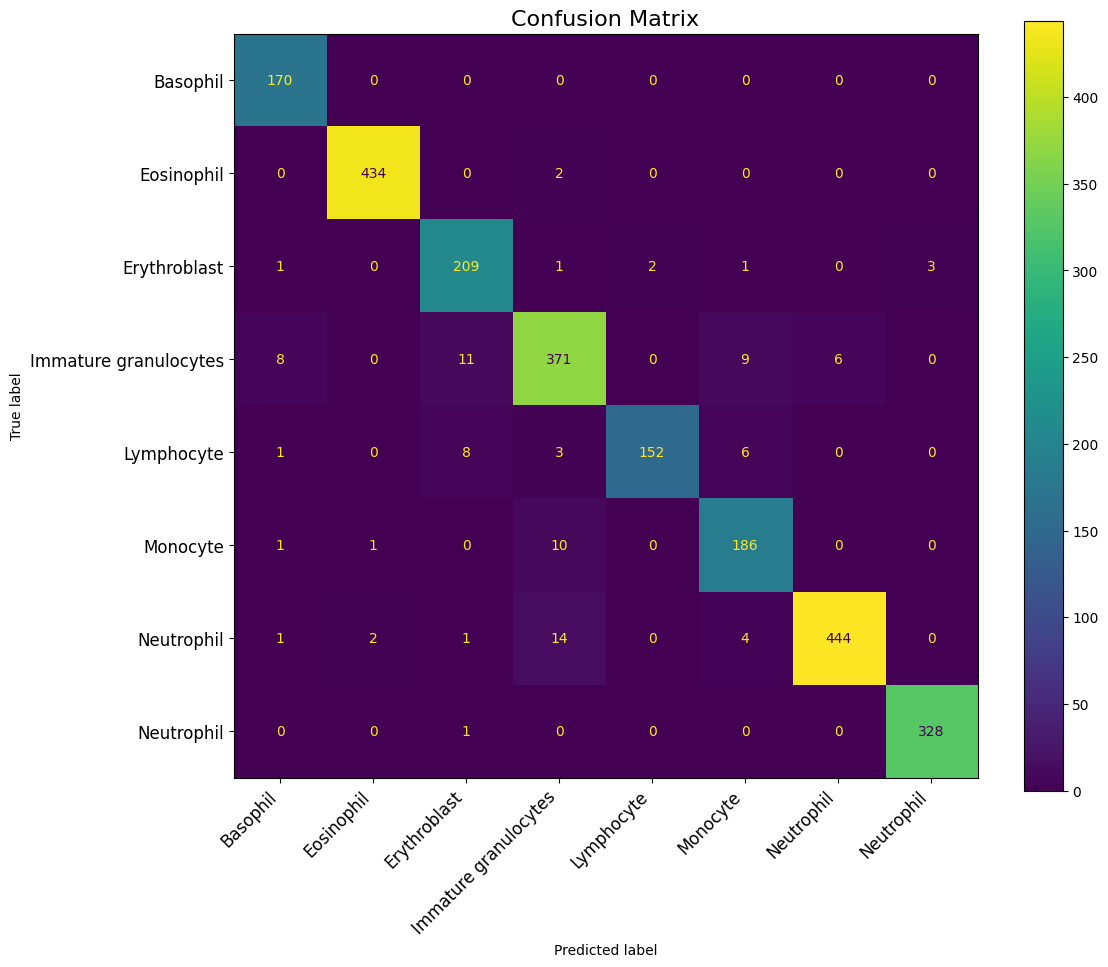

Accuracy: 95.94%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = model.predict(x_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_val.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Platelet"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Increased layer + Increased dropout**

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):

      input_layer = tfkl.Input(shape=input_shape, name='Input')

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=3)(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.45)(x)

      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.45)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_4')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.45)(x)

      global_average = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.5)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Adam(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)      │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_6  │ (None, 96, 96, 64)   │          256 │ conv2d_5[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_6           │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_4        │ (None, 32, 32, 64)   │            0 │ activation_6[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout_6 (Dropout)    │ (None, 32, 32, 64)   │            0 │ max_pooling2d_4[0]… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 32, 32, 64)   │       36,864 │ dropout_6[0][0]     │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 32, 32, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape_4 (Reshape)    │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape_4[0][0]     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_6 (Conv2D)    

 Total params: 4,780,532 (18.24 MB)

 Trainable params: 4,775,924 (18.22 MB)

 Non-trainable params: 4,608 (18.00 KB)

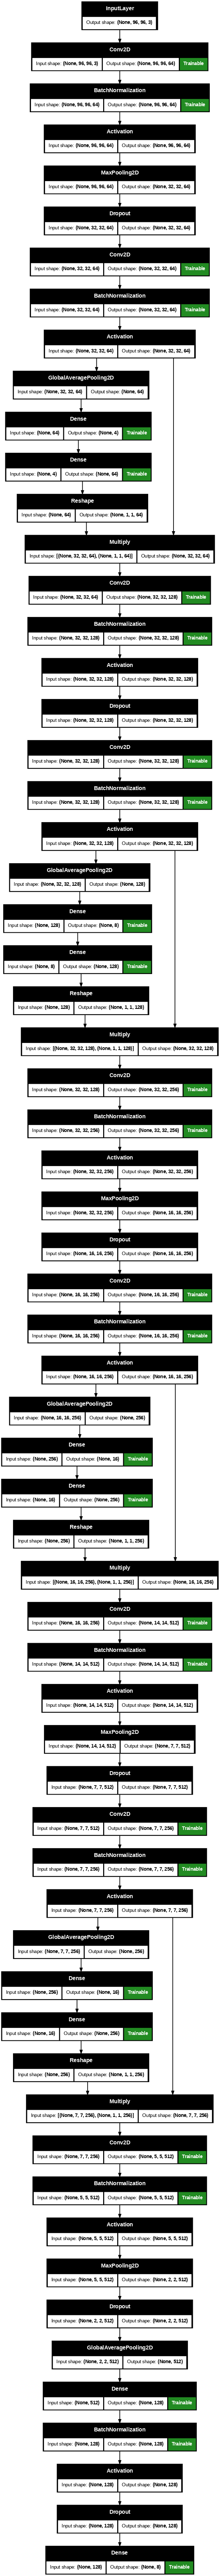

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.1927 - loss: 2.4936 - val_accuracy: 0.1380 - val_loss: 2.2343
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2642 - loss: 2.0879 - val_accuracy: 0.5065 - val_loss: 1.5254
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3300 - loss: 1.9113 - val_accuracy: 0.4743 - val_loss: 1.4142
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3646 - loss: 1.8337 - val_accuracy: 0.6688 - val_loss: 1.0565
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4036 - loss: 1.7700 - val_accuracy: 0.5905 - val_loss: 1.3139
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4163 - loss: 1.7569 - val_accuracy: 0.7056 - val_loss: 1.0371
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4354 - loss: 1.7217 - val_accuracy: 0.7344 - val_loss: 1.2632
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4496 - loss: 1.7004 

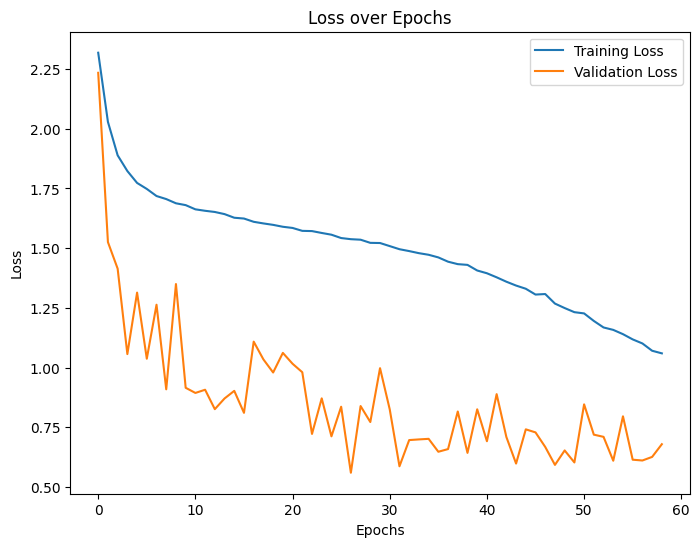

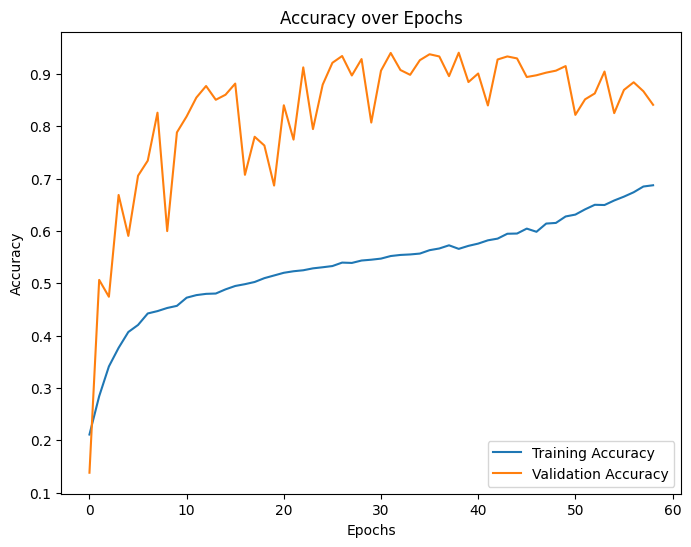

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


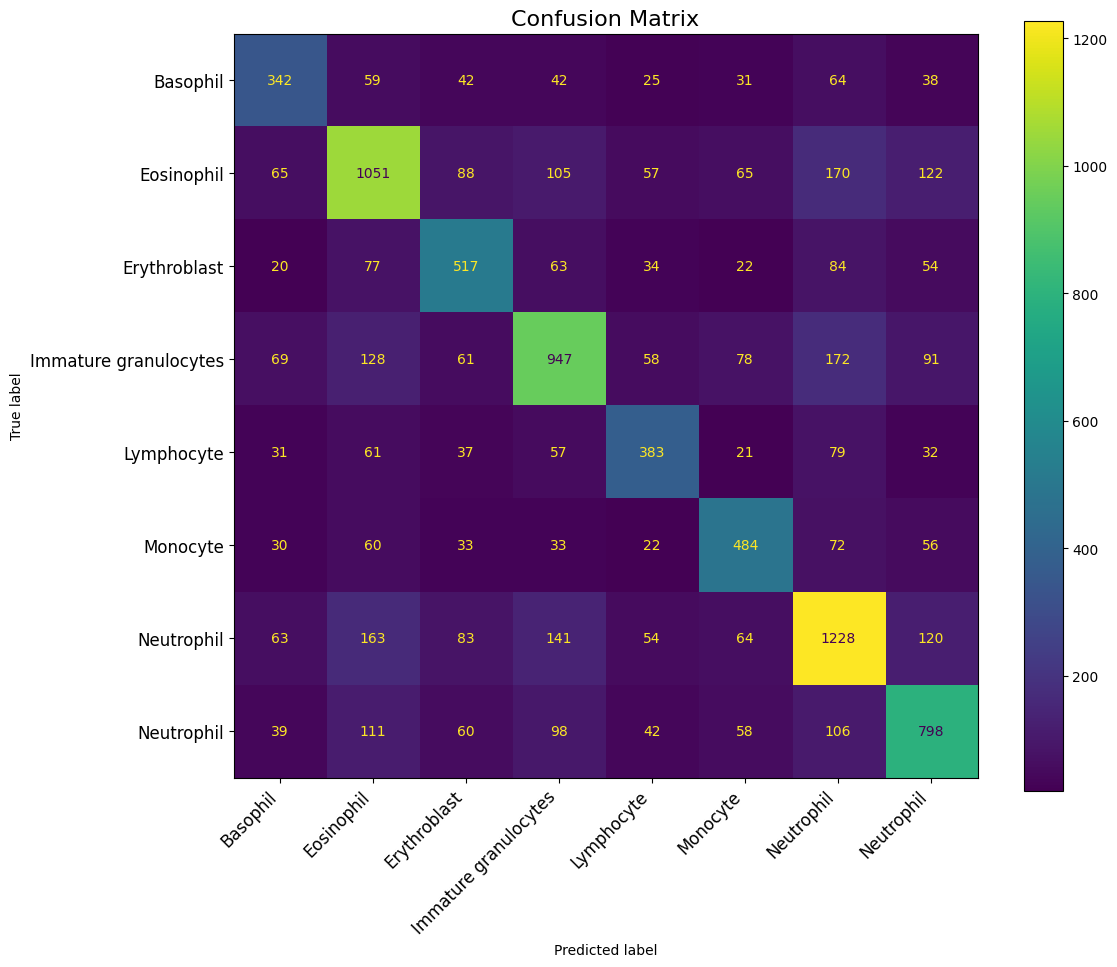

Accuracy: 60.15%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Neutrophil"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")

# **Lion + class weights + Increased dropout**

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):

      input_layer = tfkl.Input(shape=input_shape, name='Input')

      x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=2, strides=3)(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=64, kernel_size=3, downsample=False, stack=1, name='block_squeeze_1')

      x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.45)(x)

      x = senet_block(x=x, filters=128, kernel_size=3, downsample=False, stack=1, name='block_squeeze_2')

      x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.4)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_3')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.45)(x)

      x = senet_block(x=x, filters=256, kernel_size=3, downsample=False, stack=1, name='block_squeeze_4')

      x = tfkl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform')(x)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = tfkl.Dropout(0.45)(x)

      global_average = tfkl.GlobalAveragePooling2D()(x)

      x = tfkl.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(global_average)
      x = tfkl.BatchNormalization()(x)
      x = tfkl.Activation('relu')(x)
      x = tfkl.Dropout(0.5)(x)

      output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      loss = tfk.losses.CategoricalCrossentropy()
      optimizer = tfk.optimizers.Lion(learning_rate)
      metrics = ['accuracy']
      model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

      return model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 96, 96, 64)   │        1,792 │ Input[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 96, 96, 64)   │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 96, 96, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 32, 64)   │            0 │ activation[0][0]    │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 32, 32, 64)   │            0 │ max_pooling2d[0][0] │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_conv_0 │ (None, 32, 32, 64)   │       36,864 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_bn_0   │ (None, 32, 32, 64)   │          256 │ block_squeeze_1_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_act_0  │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_squee… │ (None, 64)           │            0 │ block_squeeze_1_ac… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 4)            │          260 │ block_squeeze_1_sq… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_dense… │ (None, 64)           │          320 │ block_squeeze_1_de… │    Y    │
│ (Dense)                │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ block_squeeze_1_de… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_squeeze_1_scale… │ (None, 32, 32, 64)   │            0 │ block_squeeze_1_ac… │    -    │
│ (Multiply)             │                      │              │ reshape[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)    

 Total params: 4,780,532 (18.24 MB)

 Trainable params: 4,775,924 (18.22 MB)

 Non-trainable params: 4,608 (18.00 KB)

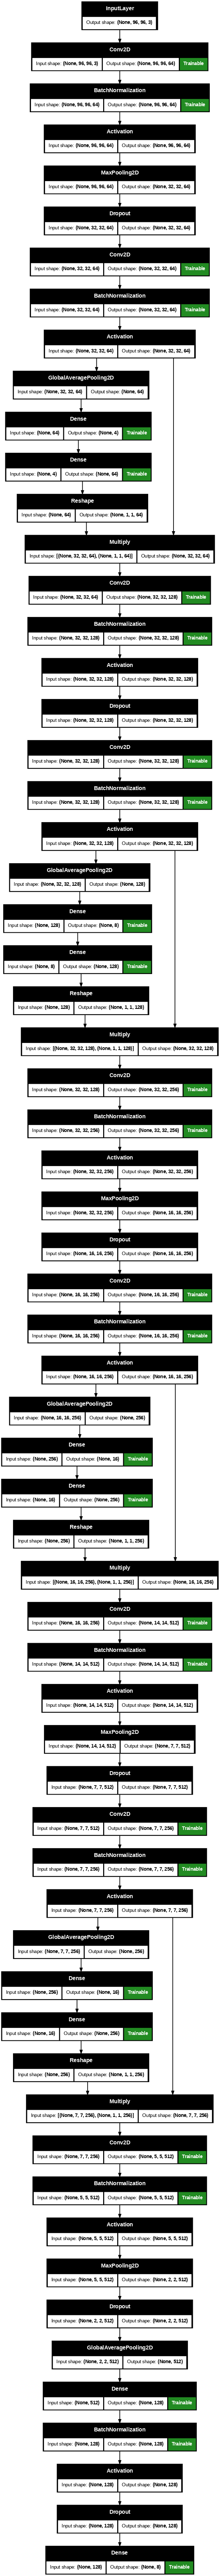

In [ ]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1445 - loss: 2.5081 - val_accuracy: 0.1694 - val_loss: 3.5078
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2024 - loss: 2.1040 - val_accuracy: 0.2882 - val_loss: 1.9717
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2314 - loss: 2.0394 - val_accuracy: 0.3367 - val_loss: 1.6854
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2523 - loss: 1.9814 - val_accuracy: 0.4258 - val_loss: 1.5818
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2538 - loss: 1.9775 - val_accuracy: 0.4914 - val_loss: 1.5478
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2537 - loss: 1.9771 - val_accuracy: 0.4994 - val_loss: 1.5900
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2415 - loss: 1.9775 - val_accuracy: 0.5341 - val_loss: 1.6222
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2539 - loss: 1.9640 

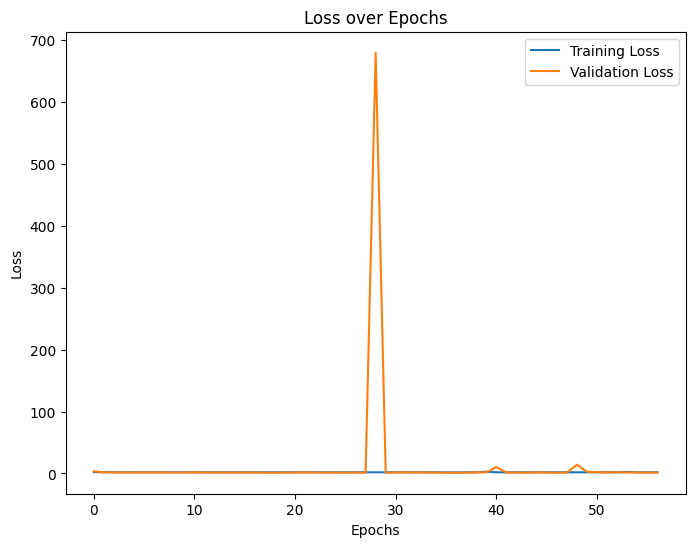

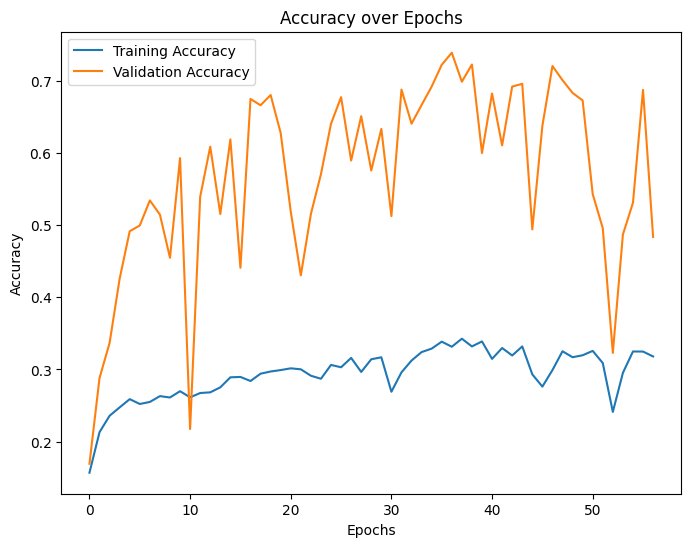

In [ ]:
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


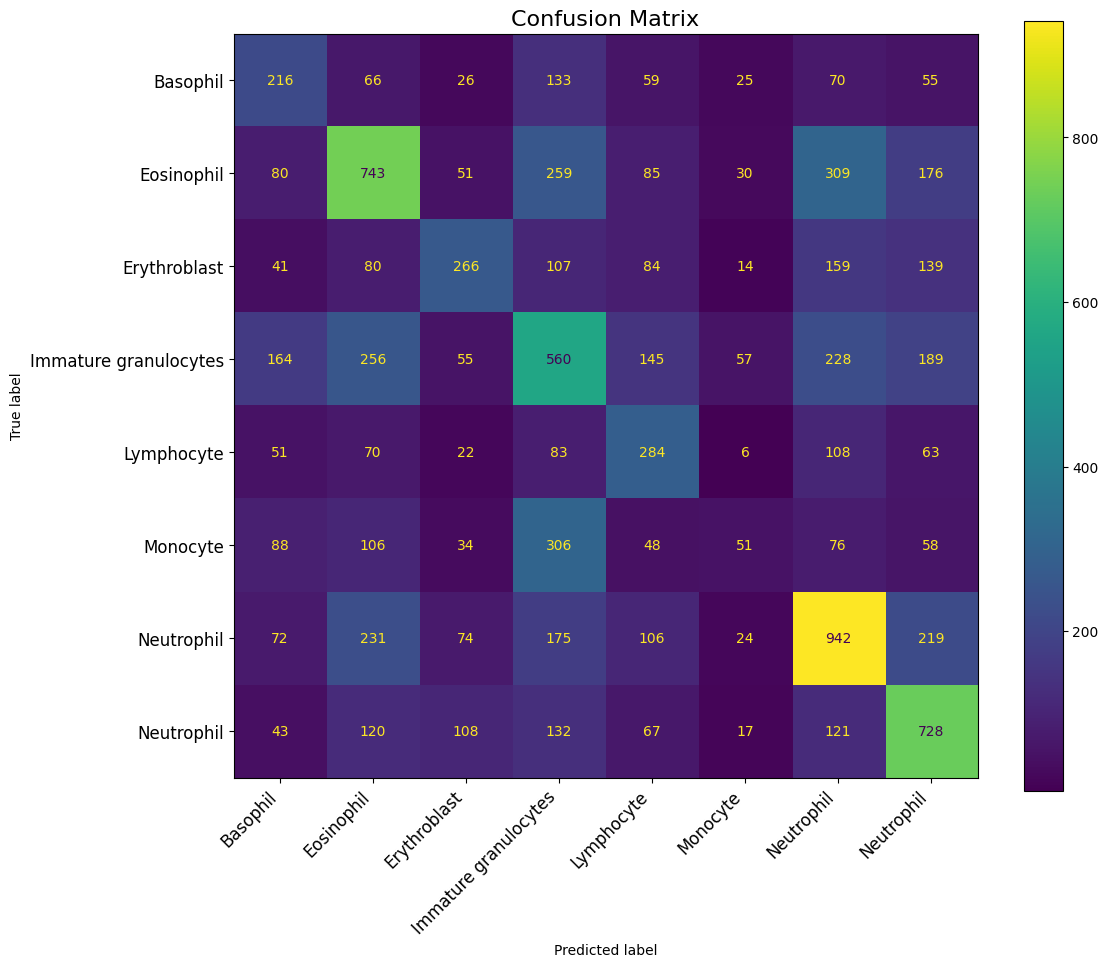

Accuracy: 39.64%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = model.predict(x_train)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_train.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
class_labels = ["Basophil", "Eosinophil", "Erythroblast",
                "Immature granulocytes", "Lymphocyte",
                "Monocyte", "Neutrophil", "Neutrophil"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="viridis", ax=ax)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2%}")